In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from collections import defaultdict

# 1、载入数据

In [3]:
train = pd.read_csv('qp_data/train.csv')
test = pd.read_csv('qp_data/test.csv')

In [4]:
display(train.head())

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [13]:
from keras.preprocessing.text import Tokenizer

def flatten(x):
    return [y for l in x for y in flatten(l)] if type(x) is list else [x]

train["question1"] = train["question1"].fillna("")
train["question2"] = train["question2"].fillna("")
test["question1"] = test["question1"].fillna("")
test["question2"] = test["question2"].fillna("")

texts_1 = train["question1"].tolist()
texts_2 = train["question2"].tolist()
test_texts_1 = test["question1"].tolist()
test_texts_2 = test["question2"].tolist()

tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

# 句子 铺平成 词语
word_sequences_1 = set(flatten(sequences_1))
word_sequences_2 = set(flatten(sequences_2))
word_test_sequences_1 = set(flatten(test_sequences_1))
word_test_sequences_2 = set(flatten(test_sequences_2))

print("训练集词表数量:%d" % (len(word_sequences_1.union(word_sequences_2))))
print("测试集词表数量:%d" % (len(word_test_sequences_1.union(word_test_sequences_2))))
print("测试集中有多少词汇不在训练集里:%d" % (len(word_test_sequences_1.union(word_test_sequences_2) - word_sequences_1.union(word_sequences_2))))

训练集词表数量:95596
测试集词表数量:101312
测试集中有多少词汇不在训练集里:41446


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

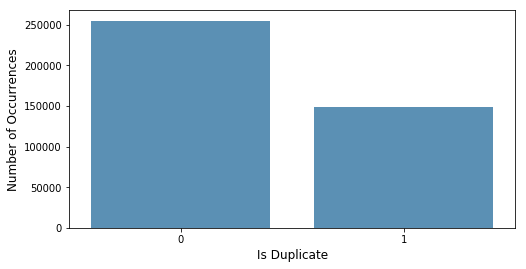

In [3]:
is_dup = train['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [4]:
is_dup / is_dup.sum()

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

In [5]:
all_ques_df = pd.DataFrame(pd.concat([train['question1'], train['question2']]))
all_ques_df.columns = ["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

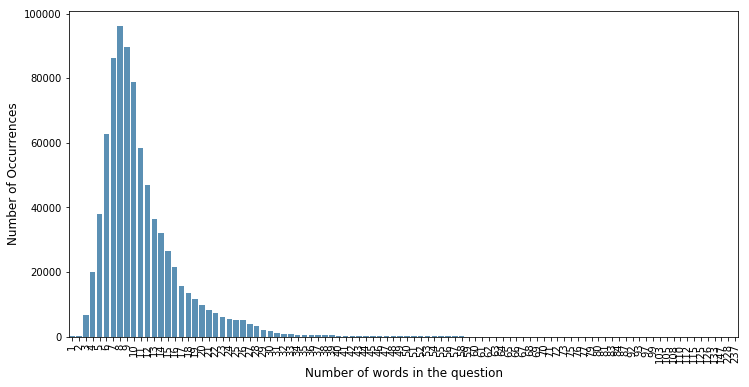

In [6]:
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

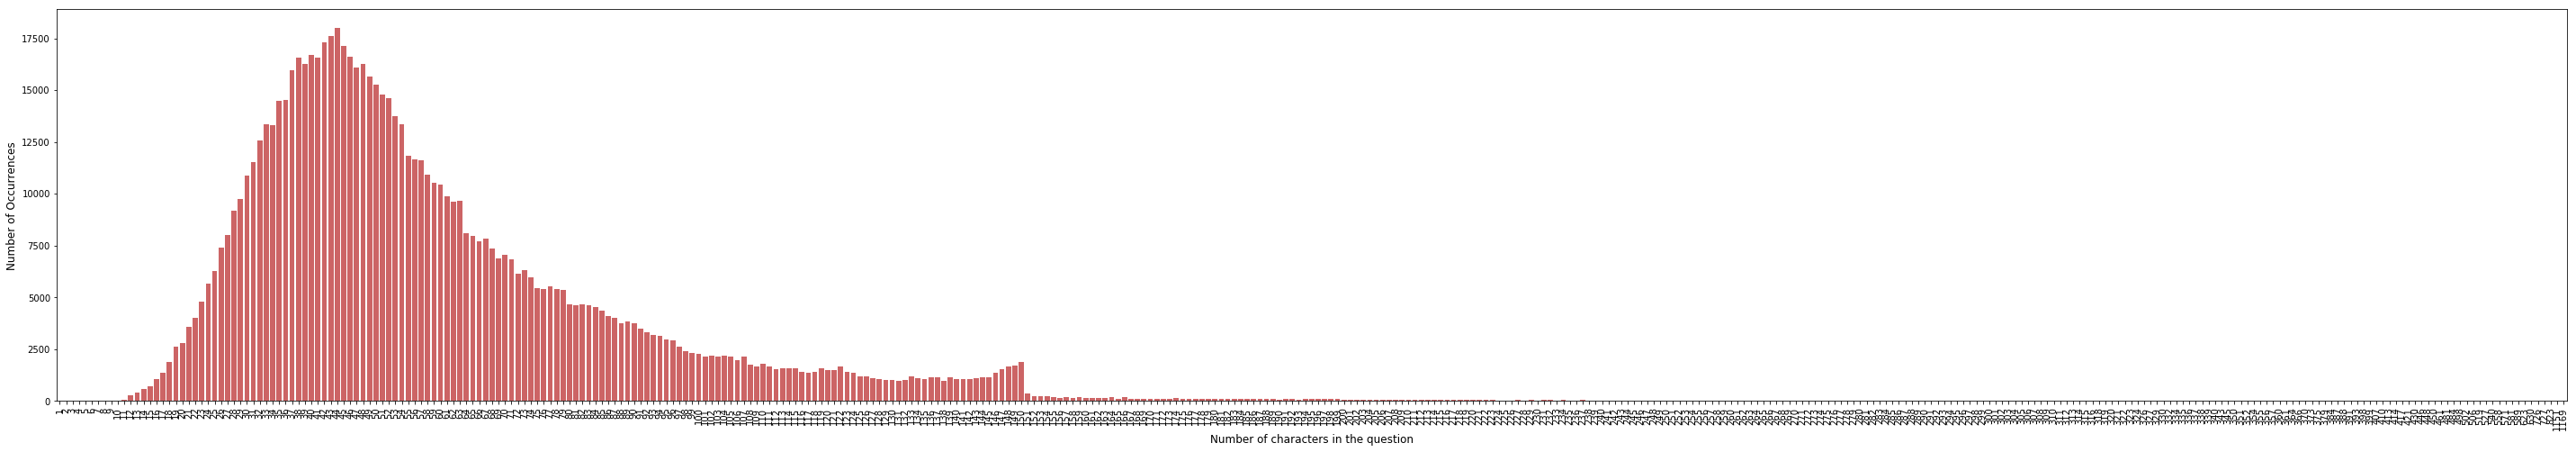

In [7]:
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))
cnt_srs = all_ques_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()      

del all_ques_df

In [10]:
def get_unigrams(que):   
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)
train_df=train

train_df["unigrams_ques1"] = train['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train.apply(lambda row: get_common_unigram_ratio(row), axis=1)

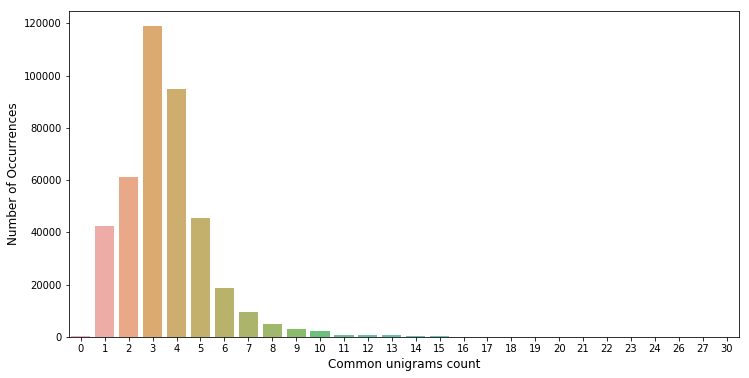

In [11]:
cnt_srs = train_df['unigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()

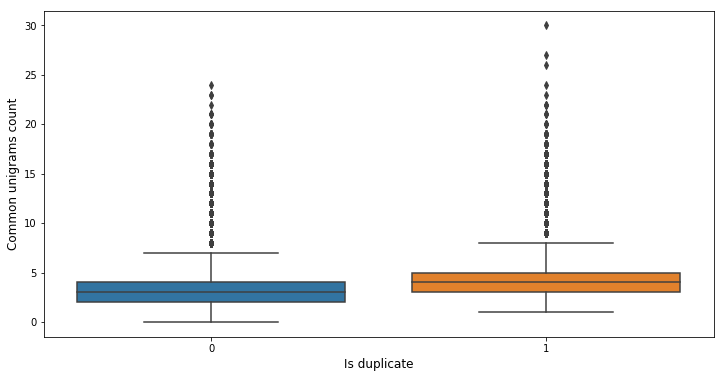

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_count", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams count', fontsize=12)
plt.show()

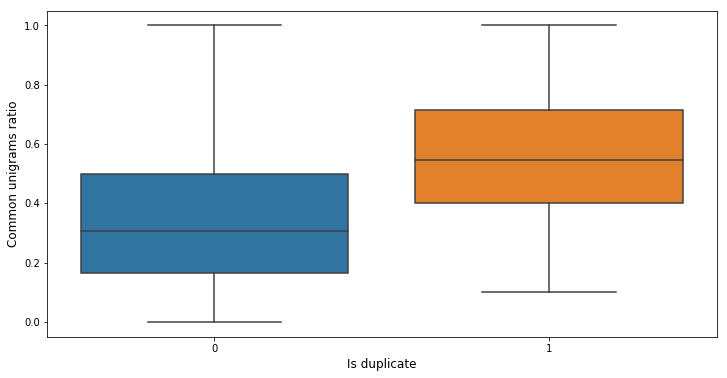

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_ratio", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams ratio', fontsize=12)
plt.show()

In [15]:
X_train = pd.read_csv('qp_data/X_train.csv')

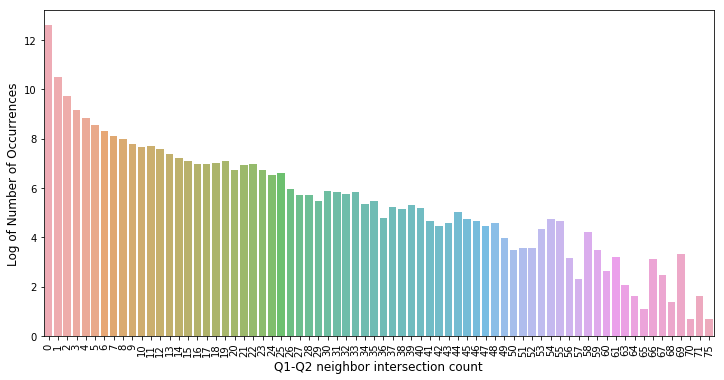

In [16]:
cnt_srs = X_train['q1_q2_intersect'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, np.log1p(cnt_srs.values), alpha=0.8)
plt.xlabel('Q1-Q2 neighbor intersection count', fontsize=12)
plt.ylabel('Log of Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

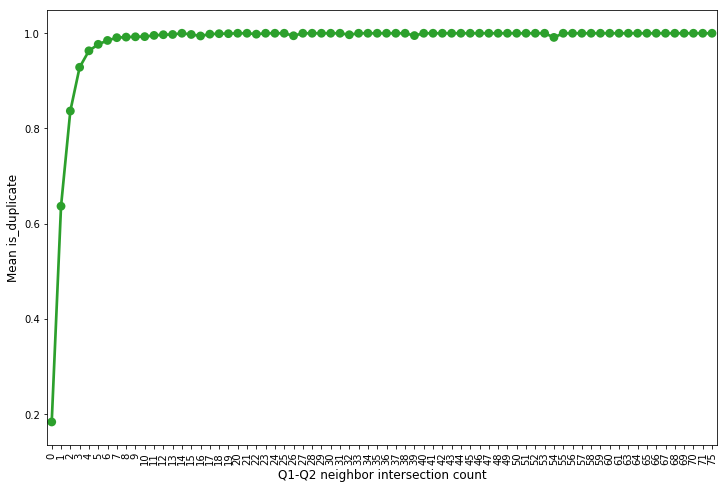

In [17]:
grouped_df = X_train.groupby('q1_q2_intersect')['is_duplicate'].aggregate(np.mean).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df["q1_q2_intersect"].values, grouped_df["is_duplicate"].values, alpha=0.8, color=color[2])
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1-Q2 neighbor intersection count', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

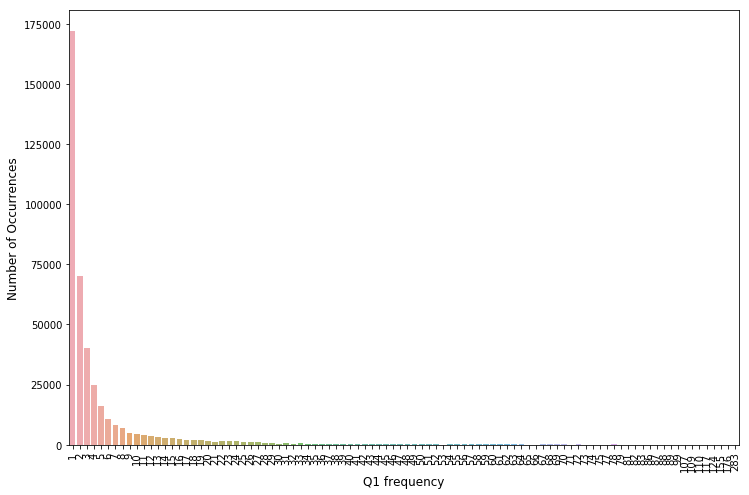

In [18]:
cnt_srs = X_train['q1_freq'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Q1 frequency', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

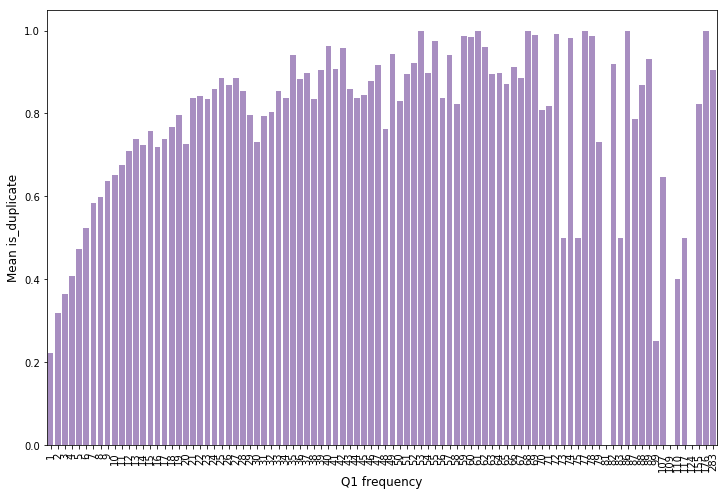

In [19]:
plt.figure(figsize=(12,8))
grouped_df = X_train.groupby('q1_freq')['is_duplicate'].aggregate(np.mean).reset_index()
sns.barplot(grouped_df["q1_freq"].values, grouped_df["is_duplicate"].values, alpha=0.8, color=color[4])
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1 frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

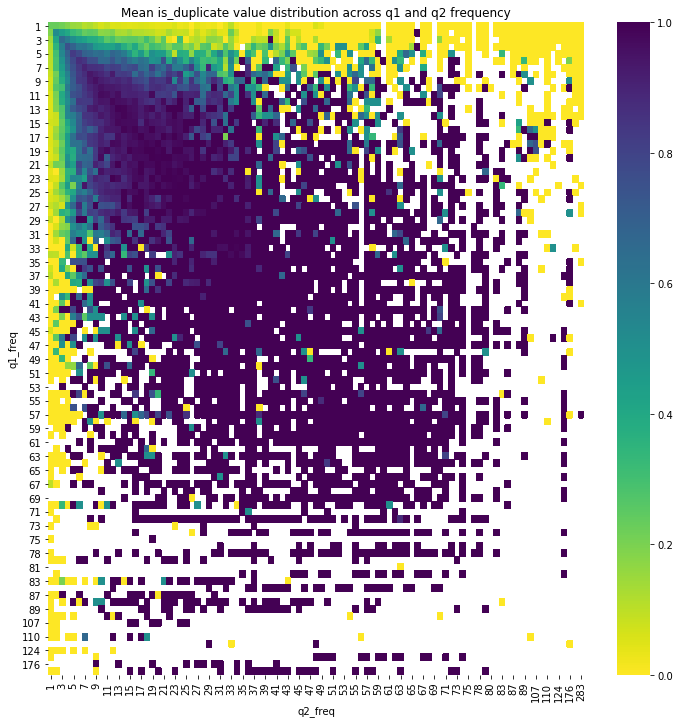

In [55]:
pvt_df = X_train.pivot_table(index="q1_freq", columns="q2_freq", values="is_duplicate")
plt.figure(figsize=(12,12))
sns.heatmap(pvt_df, cmap='viridis_r')
plt.title("Mean is_duplicate value distribution across q1 and q2 frequency")
plt.show()

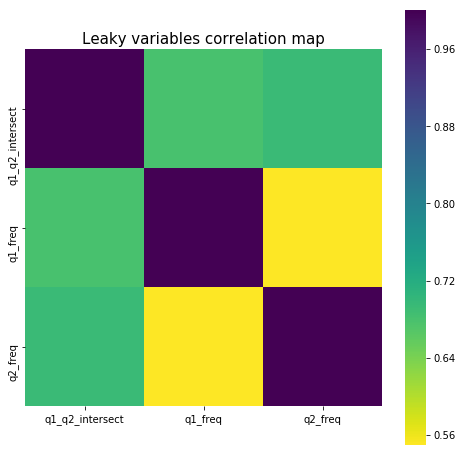

In [56]:
cols_to_use = ['q1_q2_intersect', 'q1_freq', 'q2_freq']
temp_df = X_train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., cmap='viridis_r', square=True)
plt.title("Leaky variables correlation map", fontsize=15)
plt.show()

In [9]:
test.to_csv('qp_data/test.csv', index=False)